In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

from importlib import reload
from matplotlib import rc
from neurobiases import EMSolver, TriangularModel
from scipy.optimize import root
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
K = 1

In [3]:
# Create triangular model and draw data
tm = TriangularModel(
    model='linear',
    parameter_design='direct_response',
    M=10,
    N=10,
    K=K,
    corr_cluster=0.25,
    corr_back=0.1,
    coupling_distribution='gaussian',
    coupling_sparsity=0.5,
    coupling_loc=0,
    coupling_scale=0.25,
    coupling_rng=2332,
    tuning_distribution='gaussian',
    tuning_sparsity=0.5,
    tuning_loc=0,
    tuning_scale=0.25,
    tuning_rng=23456542,
    stim_distribution='uniform')
X, Y, y = tm.generate_samples(n_samples=2000, rng=2332)

In [4]:
# Run sparse solver
solver = EMSolver(
    X, Y, y, K=K,
    solver='scipy_lbfgs',
    max_iter=20,
    tol=1e-7,
    penalize_B=False,
    rng=3370506,
    fit_intercept=False,
    Psi_transform=None,
    initialization='random',
    save_hessian=True)
print(solver.get_delta_bounds())

[-1.04038595  1.01814818]


In [5]:
solver.identifiability_transform(np.array([1.]))

In [6]:
print(solver.get_delta_bounds())

[-2.04028595  0.01824817]


In [7]:
solver.fit_em()

In [8]:
neg_gs = []
hesss = []
hess_grad = []
nits = []
xs = []
for opt in solver.all_results:
    g = opt.jac
    hess_inv = opt.hess_inv
    nit = opt.nit
    neg_gs.append(-g)
    hesss.append(hess_inv)
    nits.append(nit)
    xs.append(opt.x)
    hess_grad.append(-hess_inv.todense() @ g)

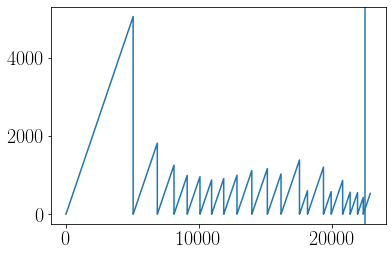

In [20]:
plt.plot(nits)
plt.axvline(22500)

In [10]:
n_em_steps = len(nits)
divide = 10
neg_g_transformed_vals = np.zeros(n_em_steps // divide + 1)
hess_grad_transformed_vals = np.zeros(n_em_steps // divide + 1)
params_transformed_vals = np.zeros_like(neg_g_transformed_vals)

for ii, iter_idx in enumerate(range(0, n_em_steps, divide)):
    copy = solver.copy()
    copy.set_all_params(xs[iter_idx])

    bounds = copy.get_delta_bounds()
    n_deltas = 25
    deltas_init = np.linspace(bounds[0], bounds[1], n_deltas)
    params = np.zeros((n_deltas, copy.n_params))

    for idx, delta in enumerate(deltas_init):
        copy2 = copy.copy()
        copy2.identifiability_transform(delta)
        params[idx] = copy2.get_params(return_Psi=True)

    pca = PCA(1)
    params_transformed = pca.fit_transform(params)
    real_params_transformed = pca.transform(xs[iter_idx][np.newaxis]).ravel()
    neg_g_transformed_vals[ii] = pca.components_ @ neg_gs[iter_idx]
    hess_grad_transformed_vals[ii] = pca.components_ @ hess_grad[iter_idx]
    params_transformed_vals[ii] = real_params_transformed.item()

(array([0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 6.000e+00, 2.800e+01, 2.050e+02,
        2.490e+02, 1.509e+03, 1.710e+02, 4.900e+01, 3.900e+01, 1.600e+01,
        7.000e+00, 2.000e+00, 3.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00]),
 array([-2.        , -1.8974359 , -1.79487179, -1.69230769, -1.58974359,
        -1.48717949, -1.38461538, -1.28205128, -1.17948718, -1.07692308,
        -0.97435897, -0.87179487, -0.76923077, -0.66666667, -0.56410256,
        -0.46153846, -0.35897436, -0.25641026, -0.15384615, -0.05128205,
         0.05128205,  0.15384615,  0.25641026,  0.35897436,  0.46153846,
         0.56410256,  0.66666667,  0.76923077,  0.87179487,  0.97435897,
         1.07692308,  1.17948718,  1.28205128,  1.38461538,  1.48717949,
  

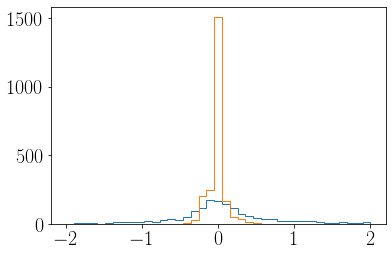

In [11]:
plt.hist(hess_grad_transformed_vals, bins=np.linspace(-2, 2, 40), histtype='step')
plt.hist(neg_g_transformed_vals, bins=np.linspace(-2, 2, 40), histtype='step')

(array([  5.,   8.,   7.,   4.,   9.,   9.,   7.,  12.,  10.,  20.,  18.,
         19.,  28.,  27.,  28.,  46.,  59.,  80., 140., 369., 154.,  94.,
         44.,  51.,  32.,  34.,  32.,  25.,  20.,  22.,  21.,  24.,  16.,
         12.,   8.,  15.,   6.,  11.,   9.]),
 array([-2.        , -1.8974359 , -1.79487179, -1.69230769, -1.58974359,
        -1.48717949, -1.38461538, -1.28205128, -1.17948718, -1.07692308,
        -0.97435897, -0.87179487, -0.76923077, -0.66666667, -0.56410256,
        -0.46153846, -0.35897436, -0.25641026, -0.15384615, -0.05128205,
         0.05128205,  0.15384615,  0.25641026,  0.35897436,  0.46153846,
         0.56410256,  0.66666667,  0.76923077,  0.87179487,  0.97435897,
         1.07692308,  1.17948718,  1.28205128,  1.38461538,  1.48717949,
         1.58974359,  1.69230769,  1.79487179,  1.8974359 ,  2.        ]),
 <BarContainer object of 39 artists>)

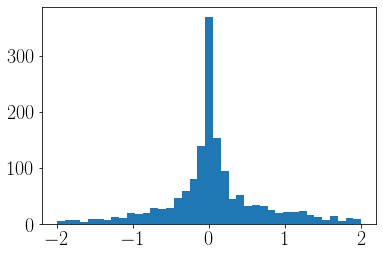

In [12]:
plt.hist(hess_grad_transformed_vals - neg_g_transformed_vals, bins=np.linspace(-2, 2, 40))

In [13]:
np.median(hess_grad_transformed_vals - neg_g_transformed_vals)

0.029160832294887168

In [26]:
print(np.median(hess_grad_transformed_vals))
print(np.median(neg_g_transformed_vals))
print(np.median(params_transformed_vals))

0.06549769097278724
0.0008844923620125586
1.7892857761646612


In [15]:
from scipy.stats import spearmanr
print(spearmanr(params_transformed_vals, hess_grad_transformed_vals).correlation)
print(spearmanr(params_transformed_vals, neg_g_transformed_vals).correlation)

-0.3314387686022247
-0.4819535052667533


(-3.0, 3.0)

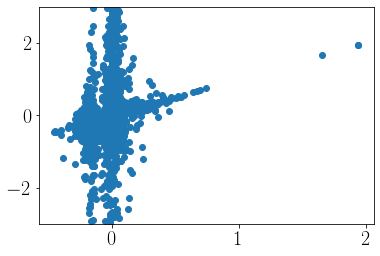

In [16]:
plt.scatter(neg_g_transformed_vals, hess_grad_transformed_vals)
plt.ylim([-3, 3])

In [21]:
iter_idx = 22500
copy = solver.copy()
copy.set_all_params(xs[iter_idx])

bounds = copy.get_delta_bounds()
n_deltas = 25
deltas_init = np.linspace(bounds[0], bounds[1], n_deltas)
params = np.zeros((n_deltas, copy.n_params))

for idx, delta in enumerate(deltas_init):
    copy2 = copy.copy()
    copy2.identifiability_transform(delta)
    print(copy2.Psi_tr_to_Psi()[0])
    params[idx] = copy2.get_params(return_Psi=True)

6.757752709688446e-06
0.0028878132267132475
0.005518321979461629
0.007898284010954802
0.010027699321192803
0.011906567910175591
0.013534889777903191
0.014912664924375613
0.01603989334959283
0.01691657505355485
0.017542710036261688
0.017918298297713322
0.018043339837909764
0.017917834656851022
0.01754178275453708
0.016915184130967948
0.016038038786143627
0.014910346720064107
0.013532107932729395
0.011903322424139494
0.010023990194294393
0.00789411124319411
0.0055136855708386185
0.002882713177227947
1.1940623620906865e-06


In [22]:
from sklearn.decomposition import PCA
pca = PCA(2)
params_transformed = pca.fit_transform(params)
real_params_transformed = pca.transform(xs[iter_idx][np.newaxis]).ravel()
neg_g_transformed = pca.components_ @ neg_gs[iter_idx]
hess_grad_transformed = pca.components_ @ hess_grad[iter_idx]

In [23]:
np.linalg.norm(hesss[iter_idx].todense() - np.identity(142)) / np.linalg.norm(np.identity(142))

45.07618878670332

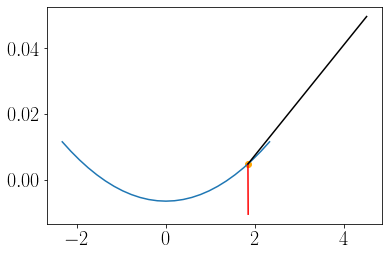

In [25]:
plt.plot(params_transformed[:, 0], params_transformed[:, 1])
plt.scatter(real_params_transformed[0], real_params_transformed[1], color='orange')
plt.plot([real_params_transformed[0], neg_g_transformed[0] + real_params_transformed[0]],
         [real_params_transformed[1], neg_g_transformed[1] + real_params_transformed[1]], color='red')
plt.plot([real_params_transformed[0], hess_grad_transformed[0] + real_params_transformed[0]],
         [real_params_transformed[1], hess_grad_transformed[1] + real_params_transformed[1]], color='black')

In [25]:
bounds = solver.get_delta_bounds()
n_deltas = 25
deltas_init = np.linspace(bounds[0], bounds[1], n_deltas)
params = np.zeros((n_deltas, solver.n_params))

for idx, delta in enumerate(deltas_init):
    copy = solver.copy()
    copy.identifiability_transform(delta)
    print(copy.Psi_tr_to_Psi()[0])
    params[idx] = copy.get_params(return_Psi=True)

4.329152645605322e-06
0.002914413368435561
0.005571443438003469
0.007975419361349323
0.010126341138473136
0.012024208769374902
0.013669022254054631
0.015060781592512309
0.01619948678474794
0.017085137830761522
0.01771773473055306
0.018097277484122556
0.018223766091470004
0.018097200552595404
0.01771758086749876
0.017084907036180073
0.016199179058639334
0.015060396934876551
0.013668560664891728
0.01202367024868485
0.010125725686255931
0.007974726977604967
0.005570674122731958
0.0029135671216369077
3.405974319786037e-06


In [26]:
from sklearn.decomposition import PCA
pca = PCA(2)
params_transformed = pca.fit_transform(params)
grad = solver.mll_grad()
grad /= np.linalg.norm(grad)
grad_transformed = pca.transform(grad[np.newaxis]).ravel()
point_transformed = pca.transform(solver.get_params(return_Psi=True)[np.newaxis]).ravel()

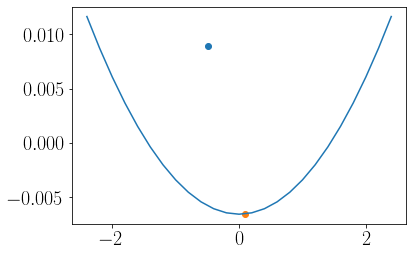

In [28]:
plt.plot(params_transformed[:, 0], params_transformed[:, 1])
plt.scatter(grad_transformed[0], grad_transformed[1])
plt.scatter(point_transformed[0], point_transformed[1])